<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1, Loss: 4.2321, Accuracy: 0.0422
Epoch 2, Loss: 4.0591, Accuracy: 0.0654
Epoch 3, Loss: 3.9815, Accuracy: 0.0808
Epoch 4, Loss: 3.9124, Accuracy: 0.0849
Epoch 5, Loss: 3.8745, Accuracy: 0.0936
Epoch 6, Loss: 3.8580, Accuracy: 0.0932
Epoch 7, Loss: 3.8253, Accuracy: 0.1053
Epoch 8, Loss: 3.7215, Accuracy: 0.1178
Epoch 9, Loss: 3.6547, Accuracy: 0.1366
Epoch 10, Loss: 3.6022, Accuracy: 0.1460
Best Hyperparameters: {'units': 240, 'hidden_activation': 'ReLU', 'optimizer': 'Adam', 'batch_size': 1000, 'lr': 0.001}
Best Accuracy: 0.1487


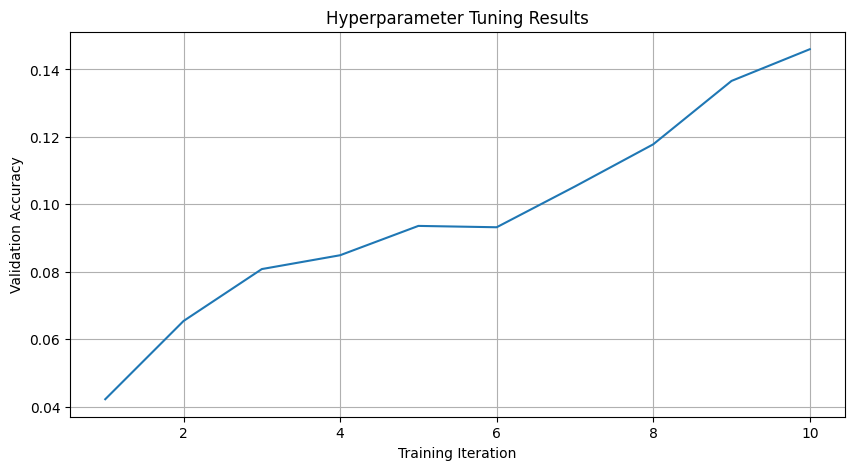

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")

# Load CIFAR-100 dataset from Google Drive
with open('/content/drive/My Drive/train', 'rb') as file:
    train_dict = pickle.load(file, encoding='bytes')

with open('/content/drive/My Drive/test', 'rb') as file:
    test_dict = pickle.load(file, encoding='bytes')

# Extract data and labels
train_data = torch.tensor(train_dict[b'data'], dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
train_labels = torch.tensor(train_dict[b'fine_labels'], dtype=torch.long)
test_data = torch.tensor(test_dict[b'data'], dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
test_labels = torch.tensor(test_dict[b'fine_labels'], dtype=torch.long)

# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transformations
train_data = torch.stack([transform(image) for image in train_data])
test_data = torch.stack([transform(image) for image in test_data])

# Create datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Define the CNN model (ResNet18)
class CIFAR100ResNet(nn.Module):
    def __init__(self):
        super(CIFAR100ResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 100)  # CIFAR-100 has 100 classes

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR100ResNet().to(device)

# Set hyperparameters
config = {
    'batch_size': 128,
    'lr': 0.1,
    'epochs': 200
}

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=5e-4, nesterov=True)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.2)

# Training function
def train_cifar100(model, train_loader, test_loader, optimizer, criterion, scheduler, device, epochs=200):
    best_accuracy = 0.0
    best_config = {}
    history = {'epoch': [], 'accuracy': []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()  # Update learning rate
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = correct / total
        history['epoch'].append(epoch + 1)
        history['accuracy'].append(val_accuracy)
        print(f'Epoch {epoch+1}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

        # Update best accuracy and config
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_config = {
                'batch_size': config['batch_size'],
                'lr': config['lr'],
                'epochs': epoch + 1
            }

    return history, best_accuracy, best_config

# Train model
history, best_accuracy, best_config = train_cifar100(
    model, train_loader, test_loader, optimizer, criterion, scheduler, device, epochs=config['epochs']
)

# Plot results
df = pd.DataFrame(history)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='epoch', y='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('CIFAR-100 Training Results')
plt.grid()
plt.savefig("/content/drive/My Drive/cifar100_training_plot.png", dpi=300)
plt.show()

# Display best accuracy and corresponding hyperparameters
print(f'Best Accuracy: {best_accuracy:.4f}')
print('Best Hyperparameters:')
for key, value in best_config.items():
    print(f'  {key}: {value}')